In [35]:
%matplotlib inline

from scipy.interpolate import interp2d

from astropy.coordinates import GCRS, CartesianRepresentation, ITRS, SphericalRepresentation
from scipy import stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from poliastro.bodies import Earth
from astropy import units as u, time
from notebooks.PlotUtil import apply_report_formatting

import cartopy.crs as ccrs


In [36]:
figures_dir = 'D:/git/thesis_report_ae/figures/visibility_analysis'

def generate_pass_df(instance_df):
    starts = instance_df.groupby(['p', 'strand_name'], as_index = False).first(1)
    starts.index.name = 'p'
    starts.rename(columns= {'tof': 'start_tof'}, inplace=True)
    ends = instance_df.groupby(['p', 'strand_name'], as_index = False).last(1)
    ends.index.name = 'p'
    ends.rename(columns= {'tof': 'end_tof'}, inplace=True)

    pass_df = pd.concat([starts, ends.end_tof], axis=1)
    pass_df['duration'] = pass_df['end_tof'] - pass_df['start_tof']

    pass_df['r_b_norm'] = np.sqrt(pass_df['r_b_x']**2 + pass_df['r_b_y']**2 + pass_df['r_b_z']**2)

    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + pass_df['start_tof'].values * u.s

    gcrs_xyz = GCRS(x=pass_df['r_a_x'], y=pass_df['r_a_y'], z=pass_df['r_a_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    pass_df['r_a_lat'] = itrs_latlon.lat.to(u.deg)
    pass_df['r_a_lon'] = itrs_latlon.lon.to(u.deg)

    return pass_df

def generate_gap_df(instances_df, step_duration = 1.0, end_tof = None):

    unique_tofs = instances_df['tof'].unique()
    gap_indexes = np.squeeze(np.argwhere(np.diff(unique_tofs) > 1.5 * step_duration))

    start_tof = unique_tofs[gap_indexes]
    end_tof = unique_tofs[gap_indexes + 1]
    duration = end_tof - start_tof
    gaps_dict = {'start_tof': start_tof,
                'end_tof': end_tof,
                'duration': duration}

    gaps_df = pd.DataFrame(gaps_dict, index=list(range(len(start_tof))) if isinstance(start_tof, np.ndarray) else [0])
    gaps_df.index.name = 'g'
    return gaps_df

# Telesat

In [37]:
columns = ['strand_name', 'tof', 'r_a_x', 'r_a_y', 'r_a_z', 'r_b_x', 'r_b_y', 'r_b_z']

#store_500km = pd.HDFStore("Test_LOSAnalysis_sat_500km_90deg_to_Telesat_2020-12-31_08-50-39.h5")
#store_500km = pd.HDFStore("2021-01-02_10-51-23_Test_LOSAnalysis_sat_500km_97deg_to_Telesat.h5")
store_500km = pd.HDFStore("2021-01-02_11-39-41_Test_LOSAnalysis_sat_500km_97deg_to_Telesat.h5")
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns))

In [38]:
#store_400km = pd.HDFStore("Test_LOSAnalysis_sat_400km_51deg_to_Telesat_2020-12-31_08-50-33.h5")
#store_400km = pd.HDFStore("2021-01-02_10-51-17_Test_LOSAnalysis_sat_400km_51deg_to_Telesat.h5")
store_400km = pd.HDFStore("2021-01-02_11-39-35_Test_LOSAnalysis_sat_400km_51deg_to_Telesat.h5")
instances_400km_df = store_400km.select('contact_instances', 'columns = %s' % str(columns))

In [39]:
pass_500km_df = generate_pass_df(instances_500km_df)
gaps_500km_df = generate_gap_df(instances_500km_df)

pass_400km_df = generate_pass_df(instances_400km_df)
gaps_400km_df = generate_gap_df(instances_400km_df)

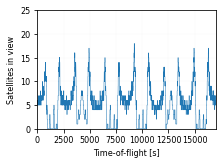

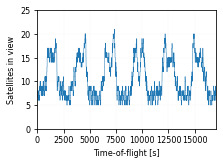

In [40]:
def contact_timeline(pass_df):
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    tof_max = 3*5677.0

    tofs = np.arange(tof_max)

    def satellites_in_view(pass_df, tofs):
        num_in_view = np.zeros((len(tofs), ))
        for i, tof in enumerate(tofs):
            in_view = (pass_df['start_tof'] <= tof) & (tof <= pass_df['end_tof'])
            num_in_view[i] = in_view.sum()
        return num_in_view

    ax.step(tofs, satellites_in_view(pass_df, tofs), linewidth=0.5)
    ax.set_xlim((0, tof_max))
    ax.set_ylim((0, 25))
    ax.set_xlabel('Time-of-flight [s]')
    ax.set_ylabel('Satellites in view')
    ax.grid(linestyle=':', linewidth = 0.1)
    apply_report_formatting()

    #plt.show()

contact_timeline(pass_500km_df)
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.svg')
plt.show()

contact_timeline(pass_400km_df)
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.svg')
plt.show()

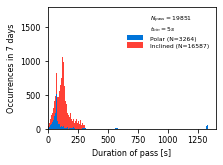

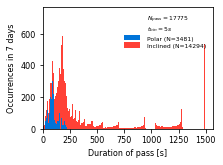

In [41]:
def plot_pass_temporal_distribution(pass_df, bin_size = 5.0):

    durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{pass} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    # Split into polar and inclined orbits
    polar_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1015*1000)
    inc_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1325*1000)

    durations_np = [durations_np[polar_sat], durations_np[inc_sat]]

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               histtype='bar',
                               stacked=True,
                               color=["#0074D9", "#FF4136"],
                               label=['Polar (N=%d)' % polar_sat.sum(),
                                      'Inclined (N=%d)' % inc_sat.sum()])

    ax.set_xlabel('Duration of pass [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.set_xlim((0, ax.get_xlim()[1]))

    #average = np.average(durations_np)
    #std_dev = np.std(durations_np)

    # ax.text(0.5, 0.90,
    #         '$N_{pass} = %d$\n' % (count) +
    #         '$t_{bin} = %ds$' % (bin_size),
    #      horizontalalignment='left',
    #      verticalalignment='top',
    #      transform = ax.transAxes)



    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

plot_pass_temporal_distribution(pass_500km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_500km97deg.pgf')
plt.show()

plot_pass_temporal_distribution(pass_400km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_400km51deg.pgf')
plt.show()

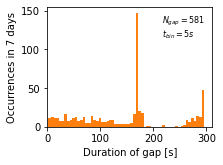

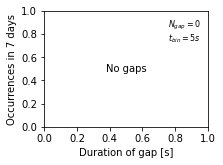

In [42]:
def plot_gap_temporal_distribution(gaps_df, bin_size = 5.0):

    durations_np = gaps_df.duration.to_numpy()
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{gap} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    ax.set_xlabel('Duration of gap [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

    if len(durations_np) == 0:
        ax.text(0.5, 0.50,
            'No gaps',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))

        return

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               stacked=True,
                               color = "tab:orange",
                               lw=0,
                               label='Gaps')


    ax.set_xlim((0, ax.get_xlim()[1]))

    average = np.average(durations_np)
    std_dev = np.std(durations_np)

plot_gap_temporal_distribution(gaps_500km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_500km97deg.pgf')
plt.show()

plot_gap_temporal_distribution(gaps_400km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_400km51deg.pgf')
plt.show()

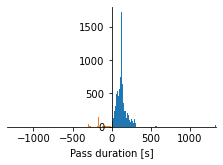

In [43]:
def plot_pass_gap_temporal_distribution(pass_df, gap_df, bin_size = 5.0):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    pass_durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(pass_durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(pass_durations_np, bins=bins, stacked=True)

    gap_durations_np = gap_df.duration.to_numpy()

    bins = int(np.max(gap_durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(-1*gap_durations_np, bins=bins, stacked=True)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(max(pass_durations_np.max(), gap_durations_np.max()) * np.array([-1, 1]))
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel('Pass duration [s]')
    #ax.set_xticks(abs(ax.get_xticks()))
    #ax.set_xticklabels([''] + str(abs(ax.get_xticks())))

plot_pass_gap_temporal_distribution(pass_500km_df, gaps_500km_df)
pass

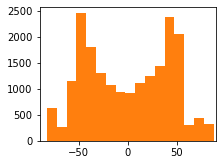

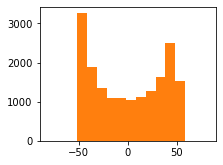

In [44]:
def plot_pass_spatial_occurance_distribution(pass_df):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    llat = pass_df['r_a_lat']

    bin_width = 10
    bins_llat = np.arange(min(llat), max(llat) + bin_width, bin_width)

    n, bins, patches = ax.hist(llat,
                            stacked=True,
                            #density=True,
                            bins=bins_llat,
                            color = "tab:orange",
                            lw=0,
                            label='Gaps')

    ax.set_xlim((-90, 90))


plot_pass_spatial_occurance_distribution(pass_500km_df)
plt.show()

plot_pass_spatial_occurance_distribution(pass_400km_df)
plt.show()

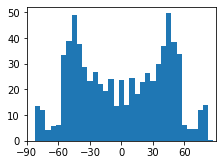

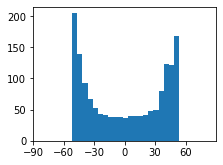

In [45]:
def plot_pass_spatial_temporal_distribution(pass_df):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    llat = pass_df['r_a_lat']
    durations = pass_df['duration']

    bin_width = 5
    bins_llat = np.arange(min(llat), max(llat) + bin_width, bin_width)

    bin_min, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='min', bins=bins_llat)

    bin_mean, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='mean', bins=bins_llat)

    bin_max, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='max', bins=bins_llat)

    bin_sum, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='sum', bins=bins_llat)
    bin_sum = bin_sum / 60 / 60

    x = (bin_edges[:-1] + bin_edges[1:])/2
    w = bin_edges[1:] - bin_edges[:-1]
    ax.bar(x, bin_sum, w)

    ax.set_xticks(np.arange(-90, 90, 30))

    #ax.hlines(bin_sum, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
    #           label='binned statistic of data')
    #ax.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_sum)
    #
    # y = bin_mean
    #
    # y_pos = bin_max - bin_mean
    # y_neg = -1*(bin_mean - bin_min)
    # plt.errorbar(x, y, yerr=np.array([-1*y_neg, y_pos]),
    #          label='uplims=True, lolims=True')

    ax.set_xlim((-90, 90))

plot_pass_spatial_temporal_distribution(pass_500km_df)
plt.show()

plot_pass_spatial_temporal_distribution(pass_400km_df)
plt.show()

In [46]:
def generate_single_tof_df(instances_df):

    # We first reduce the data set to a single entry per tof (as the satellite is only at one position
    # at a time of flight
    single_tof_df = instances_df.groupby(['tof'], as_index = False).first(1)

    # Then we calculate the lat-longs
    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + single_tof_df['tof'].values * u.s
    gcrs_xyz = GCRS(x=single_tof_df['r_a_x'], y=single_tof_df['r_a_y'], z=single_tof_df['r_a_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    single_tof_df['r_a_lat'] = itrs_latlon.lat.to(u.deg)
    single_tof_df['r_a_lon'] = ((itrs_latlon.lon + np.pi * u.rad) % (2*np.pi * u.rad) - np.pi * u.rad).to(u.deg)

    return single_tof_df

single_tof_500km_df = generate_single_tof_df(instances_500km_df)
single_tof_400km_df = generate_single_tof_df(instances_400km_df)

In [ ]:
def plot_contact_time_spatial_distribution(single_tof_df):

    # Each lat-long in the df now indicates that there is los at that lat-long at that time
    # Next we plot them on a map counting the amount
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    bin_width = 1
    bins_llon = np.arange(-180, 180 + bin_width, bin_width)
    bins_llat = np.arange(-90, 90 + bin_width, bin_width)

    counts, xedges, yedges, im = ax.hist2d(single_tof_df['r_a_lon'], single_tof_df['r_a_lat'],
              bins=[bins_llon, bins_llat],
              #cmap=plt.get_cmap('coolwarm')
              )
    # Add the colorbar axes anywhere in the figure. Its position will be
    # re-calculated at each figure resize.
    #cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(im,cax=cax,extend='both',**kw)

    #plt.colorbar(im, cax = cbar_ax)
    ax.set_extent([-180, 180, -90, 90])

plot_contact_time_spatial_distribution(single_tof_500km_df)
plt.savefig(figures_dir + '/Telesat_spatial_distribution_500km97deg.svg')
plt.savefig(figures_dir + '/Telesat_spatial_distribution_500km97deg.pgf')
plt.show()

plot_contact_time_spatial_distribution(single_tof_400km_df)
plt.savefig(figures_dir + '/Telesat_spatial_distribution_400km51deg.svg')
plt.savefig(figures_dir + '/Telesat_spatial_distribution_400km51deg.pgf')
plt.show()

In [ ]:
def plot_temporal_coverage(instances_df, pass_df, t_end = None, min_durations=np.arange(0, 315, 15)):

    if t_end is None:
        t_end = instances_df['tof'].values[-1]

    percentages = np.zeros((len(min_durations),))

    for i, min_duration in enumerate(min_durations):

        # First we find which passes are long enough to include:
        long_passes = pass_df[pass_df.duration > min_duration]

        # And use that to filter the instances
        long_instances_df = instances_df[instances_df.index.isin(long_passes.index, level='p')]

        # Then we compute the gaps
        long_gap_df = generate_gap_df(long_instances_df)

        # Then we compute the total gap duration
        total_gap_duration = long_gap_df[long_gap_df['end_tof'] < t_end].duration.sum()

        # And compute the coverage percentage
        percentages[i] = 1 - total_gap_duration / t_end

    ## DO PLOTTING
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))
    ax.plot(min_durations, percentages * 100, '-+', linewidth=0.5)
    ax.set_xlabel('Minimum contact time [s]')
    ax.set_ylabel('Coverage [%]')
    ax.grid(linestyle=':', linewidth=0.1)
    ax.set_xlim((0, max(min_durations)))
    apply_report_formatting()

plot_temporal_coverage(instances_500km_df, pass_500km_df)
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_500km97deg.svg')
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_500km97deg.pgf')
plt.show()

plot_temporal_coverage(instances_400km_df, pass_400km_df)
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_400km51deg.svg')
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_400km51deg.pgf')
plt.show()

In [ ]:
def plot_coverage_spatial(coverage_df):

    # Calculate lat longs
    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + coverage_df['tof'].values * u.s
    gcrs_xyz = GCRS(x=coverage_df['r_x'], y=coverage_df['r_y'], z=coverage_df['r_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    coverage_df['r_lat'] = itrs_latlon.lat.to(u.deg)
    coverage_df['r_lon'] = ((itrs_latlon.lon + np.pi * u.rad) % (2*np.pi * u.rad) - np.pi * u.rad).to(u.deg)

    ## Plotting
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)


    # # f = interp2d(coverage_df['r_lon'].to_numpy(), coverage_df['r_lat'].to_numpy(),
    # #                          coverage_df['los'].to_numpy() * 1.0, kind='linear')
    step = 1
    llon = np.arange(-180, 180 + step, step)
    llat = np.arange(-90, 90 + step, step)
    # # val = f(llon, llat)
    # #
    # # llon_mesh, llat_mesh = np.meshgrid(llon, llat)
    # # ax.pcolormesh(llon_mesh, llat_mesh, val)
    #
    # import matplotlib.tri as tri
    # triang = tri.Triangulation(coverage_df['r_lon'], coverage_df['r_lat'])
    # interpolator = tri.LinearTriInterpolator(triang, coverage_df['los'] * 1.0)
    # val = interpolator(llon, llat)
    from scipy.interpolate import griddata
    val = griddata((coverage_df['r_lon'], coverage_df['r_lat']), coverage_df['num_los'],
                   (llon[None,:], llat[:,None]), method='linear')

    im = ax.contourf(llon, llat, val, cmap=plt.get_cmap('coolwarm'))

    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(im, cax=cax,extend='both',**kw)

    # llon = coverage_df[coverage_df['los']].r_lon
    # llat = coverage_df[coverage_df['los']].r_lat
    #
    # ax.scatter(llon, llat)

    #ax.contourf(coverage_df['r_lon'], coverage_df['r_lat'], coverage_df['los'] * 1.0)
    # counts, xedges, yedges, im = ax.hist2d(coverage_df['r_lon'], coverage_df['r_lat'],
    #       bins=[bins_llon, bins_llat],
    #       #cmap=plt.get_cmap('coolwarm')
    #       )


columns = ['tof', 'r_x', 'r_y', 'r_z', 'num_los']

coverage_list = [
    (pd.HDFStore('2021-01-03_09-09-00_COVAnalysis-400km.h5'), "400km"),
    (pd.HDFStore('2021-01-03_09-09-00_COVAnalysis-500km.h5'), "500km"),
    (pd.HDFStore('2021-01-03_09-09-00_COVAnalysis-1000km.h5'), "1000km"),
    (pd.HDFStore('2021-01-03_09-09-00_COVAnalysis-1300km.h5'), "1300km"),
]

for coverage_item in coverage_list:
    coverage_df = coverage_item[0].select('coverage', 'columns = %s' % str(columns))
    plot_coverage_spatial(coverage_df)
    #plt.title(coverage_item[1])
    plt.savefig(figures_dir + '/Telesat_spatial_coverage_%s.svg' % coverage_item[1])
    plt.savefig(figures_dir + '/Telesat_spatial_coverage_%s.pgf' % coverage_item[1])
    plt.show()